In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gala.coordinates as galacoord
from astropy.coordinates import SkyCoord
import pandas as pd

In [2]:
# import Gaia querey and Galstreams GD1 track
gaia_df = pd.read_csv('gaia_gd1_query.csv')
gd1_track = pd.read_csv('GD-1-I21_track.csv')

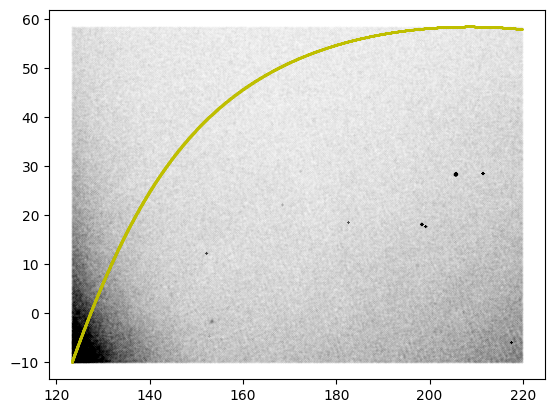

In [3]:
#Visualize the data in RA, DEC
plt.scatter(gaia_df['ra'], gaia_df['dec'], c='k', s=0.1, alpha=0.01, label='Gaia')
plt.scatter(gd1_track['ra'], gd1_track['dec'], c='y', s=0.1, label='Galstreams')

In [4]:
# Rotate into stream frame
gaia_df['phi1'] = SkyCoord(ra=gaia_df['ra'], dec=gaia_df['dec'], unit='deg').transform_to(galacoord.GD1Koposov10).phi1.deg
gaia_df['phi2'] = SkyCoord(ra=gaia_df['ra'], dec=gaia_df['dec'], unit='deg').transform_to(galacoord.GD1Koposov10).phi2.deg

In [5]:
# Rotate into stream frame
gd1_track['phi1'] = SkyCoord(ra=gd1_track['ra'], dec=gd1_track['dec'], unit='deg').transform_to(galacoord.GD1Koposov10).phi1.deg
gd1_track['phi2'] = SkyCoord(ra=gd1_track['ra'], dec=gd1_track['dec'], unit='deg').transform_to(galacoord.GD1Koposov10).phi2.deg

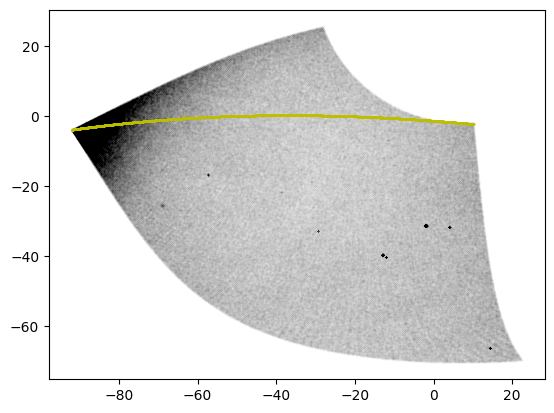

In [6]:
plt.scatter(gaia_df['phi1'], gaia_df['phi2'], c='k', s=0.1, alpha=0.01, label='Gaia')
plt.scatter(gd1_track['phi1'], gd1_track['phi2'], c='y', s=0.1, label='Galstreams')

In [7]:
from scipy.interpolate import interp1d
def betw(y_data, fit_data, delta):
    ''' Cuts delta around Galstreams track'''
    return (y_data > fit_data - delta) & (y_data < fit_data + delta)

phi_fit = interp1d(gd1_track['phi1'], gd1_track['phi2'], kind='linear', fill_value='extrapolate')
pmra_fit = interp1d(gd1_track['phi1'], gd1_track['pmra'], kind='linear', fill_value='extrapolate')
pmdec_fit = interp1d(gd1_track['phi1'], gd1_track['pmdec'], kind='linear', fill_value='extrapolate')
dist_fit = interp1d(gd1_track['phi1'], gd1_track['distance'], kind='linear', fill_value='extrapolate')
#vrad_fit = interp1d(galstream_phi1, gd1_track['ra']dial_velocity, kind='linear', fill_value='extrapolate') # Uncomment if you have lots of radial velocities for the stream

gaia_cut_phi2 = betw(gaia_df['phi2'], phi_fit(gaia_df['phi1']), 5)
gaia_cut_pmra = betw(gaia_df['pmra'], pmra_fit(gaia_df['phi1']), 0.5)
gaia_cut_pmdec = betw(gaia_df['pmdec'], pmdec_fit(gaia_df['phi1']), 0.5)
gaia_cut_dist = betw(1/gaia_df['parallax'], dist_fit(gaia_df['phi1']), 10)

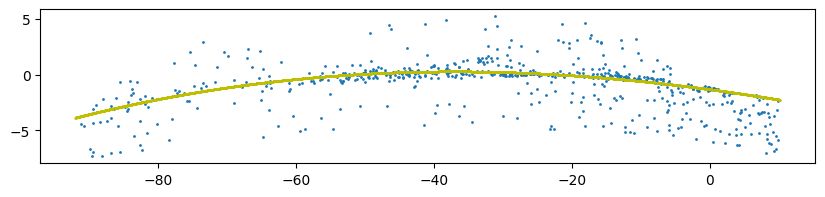

In [8]:
# Visualize remaining candidates
fig, ax = plt.subplots(1, figsize=(10, 2))
ax.scatter(gaia_df['phi1'][gaia_cut_phi2 & gaia_cut_pmra & gaia_cut_pmdec & gaia_cut_dist], gaia_df['phi2'][gaia_cut_phi2 & gaia_cut_pmra & gaia_cut_pmdec & gaia_cut_dist], s=1, alpha=1, label='Gaia')
ax.scatter(gd1_track['phi1'], gd1_track['phi2'], c='y', s=0.1, label='Galstreams')

# Scoring

In [9]:
from astropy.io import fits

# Read the FITS file
streamfinder = fits.open('/Users/nasserm/Documents/vscode/research/data/streamfinder_gaiadr3.fits')
streamfinder_data = streamfinder[1].data  # Access the first data extension
streamfinder.close()  # Close the file after reading

# Convert to pandas DataFrame for consistency with existing code
streamfinder_df = pd.DataFrame(streamfinder_data)

In [10]:
gd1_candidate_members_df = pd.read_csv('gd1_candidate_members.csv')
gd1_candidate_members_df.head()

,SOURCE_ID,ra,dec
0,3092469911608731776,129.158970,4.676782
1,694411691103568256,141.568483,26.967785
2,694440995663781632,141.695001,27.176999
3,694539814271564544,142.014262,27.324229
4,694571493950089856,141.900723,27.771087


In [11]:
arr = np.array(streamfinder_data)
fixed_arr = arr.byteswap().view(arr.dtype.newbyteorder('='))
streamfinder_df = pd.DataFrame(fixed_arr)
gd1_streamfinder_df = streamfinder_df[streamfinder_df['Stream'] == 53]
gd1_streamfinder_df.head()

,Gaia,RAdeg,DEdeg,plx,pmRA,pmDE,Gmag,B-R,VHel,e_VHel,r_VHel,Stream
10564,5713049502967159680,120.997761,-20.791694,0.207,-0.888,-4.869,13.91,1.04,353.4,4.1,3,53
10565,5727918714100939776,122.727165,-11.443705,0.109,-1.051,-8.294,16.85,0.91,310.2,11.8,14,53
10566,3064201330223846144,124.226471,-6.423482,-0.480,-1.201,-9.402,18.67,0.67,0.0,300.0,0,53
10567,3064294273312979328,124.595287,-6.180825,0.370,-0.780,-9.296,17.10,0.89,0.0,300.0,0,53
10568,3065953814315574656,124.908863,-5.089101,0.115,-1.349,-9.181,17.76,0.74,0.0,300.0,0,53


In [12]:
# Create sets of Gaia IDs from the "true positives" and the candidate members
streamfinder_ids = set(gd1_streamfinder_df['Gaia'])
candidate_ids = set(gd1_candidate_members_df['SOURCE_ID'])

# True positives: IDs that appear in both sets
tp_ids = streamfinder_ids.intersection(candidate_ids)

# False negatives: true positives that were missed by the candidate test
fn_ids = streamfinder_ids - candidate_ids

# False positives: candidate IDs that are not in the true set
fp_ids = candidate_ids - streamfinder_ids

tp_count = len(tp_ids)
fn_count = len(fn_ids)
fp_count = len(fp_ids)

# Calculate precision and recall metrics
precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0

print("AI Score:")
print(f"True Positives: {tp_count}")
print(f"False Negatives: {fn_count}")
print(f"False Positives: {fp_count}")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

AI Score:
True Positives: 200
False Negatives: 1268
False Positives: 143
Precision: 58.31%
Recall: 13.62%


In [16]:
# Use gaia_df with the mask as the candidate test
candidate_ids_test = set(gaia_df['source_id'])
streamfinder_ids = set(gd1_streamfinder_df['Gaia'])

# True positives: IDs that appear in both sets
tp_ids = streamfinder_ids.intersection(candidate_ids_test)
# False negatives: streamfinder IDs missed by the Gaia cuts
fn_ids = streamfinder_ids - candidate_ids_test
# False positives: Gaia cut IDs that are not in the streamfinder set
fp_ids = candidate_ids_test - streamfinder_ids

tp_count = len(tp_ids)
fn_count = len(fn_ids)
fp_count = len(fp_ids)

precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0

print("My Score:")
print(f"True Positives: {tp_count}")
print(f"False Negatives: {fn_count}")
print(f"False Positives: {fp_count}")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

My Score:
True Positives: 457
False Negatives: 1011
False Positives: 1442656
Precision: 0.03%
Recall: 31.13%


In [14]:
# Compare candidate test members from Gaia (with the cuts) with the candidate members sample

# Get candidate test IDs (from Gaia with our cuts) and the correct sample (candidate members)
candidate_ids_test = set(gaia_df['source_id'][gaia_cut_phi2 & gaia_cut_pmra & gaia_cut_pmdec & gaia_cut_dist])
correct_ids = set(gd1_candidate_members_df['SOURCE_ID'])

# True positives: candidates that are in the correct sample
tp_ids = candidate_ids_test.intersection(correct_ids)
# False negatives: correct sample IDs missed by the candidate test
fn_ids = correct_ids - candidate_ids_test
# False positives: candidate test IDs that are not in the correct sample
fp_ids = candidate_ids_test - correct_ids

tp_count = len(tp_ids)
fn_count = len(fn_ids)
fp_count = len(fp_ids)

precision = tp_count / (tp_count + fp_count) if (tp_count + fp_count) > 0 else 0
recall = tp_count / (tp_count + fn_count) if (tp_count + fn_count) > 0 else 0

print("AI to Me:")
print(f"True Positives: {tp_count}")
print(f"False Negatives: {fn_count}")
print(f"False Positives: {fp_count}")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")

AI to Me:
True Positives: 229
False Negatives: 114
False Positives: 393
Precision: 36.82%
Recall: 66.76%


In [20]:
gd1_streamfinder_df.head()

,Gaia,RAdeg,DEdeg,plx,pmRA,pmDE,Gmag,B-R,VHel,e_VHel,r_VHel,Stream
10564,5713049502967159680,120.997761,-20.791694,0.207,-0.888,-4.869,13.91,1.04,353.4,4.1,3,53
10565,5727918714100939776,122.727165,-11.443705,0.109,-1.051,-8.294,16.85,0.91,310.2,11.8,14,53
10566,3064201330223846144,124.226471,-6.423482,-0.480,-1.201,-9.402,18.67,0.67,0.0,300.0,0,53
10567,3064294273312979328,124.595287,-6.180825,0.370,-0.780,-9.296,17.10,0.89,0.0,300.0,0,53
10568,3065953814315574656,124.908863,-5.089101,0.115,-1.349,-9.181,17.76,0.74,0.0,300.0,0,53


(-10.0, 10.0)

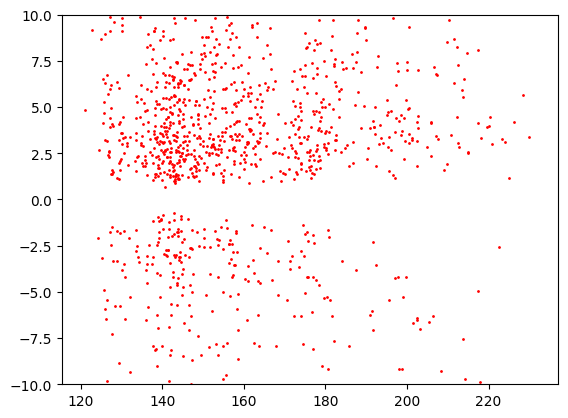

In [22]:
plt.scatter(gd1_streamfinder_df['RAdeg'], 1/gd1_streamfinder_df['plx'], c='r', s=1, label='Streamfinder')
plt.ylim(-10, 10)

In [15]:
## Could consider an isochrone cut
#plt.scatter(gaia_df['bp_rp'][gaia_cut_phi2 & gaia_cut_pmra & gaia_cut_pmdec], gaia_df['phot_g_mean_mag'][gaia_cut_phi2 & gaia_cut_pmra & gaia_cut_pmdec], c='k', s=1, alpha=1, label='Gaia')